<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
## openEO Platform NDVI time series analysis

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd

import openeo
from openeo.processes import array_create,mean,sd
from openeo.extra.spectral_indices import compute_indices

In [2]:
crop_samples = {
    crop_type: gpd.read_file(f"crop_parcels/{crop_type}_2019.geojson", driver='GeoJSON') 
    for crop_type in ["maize", "potatos", "sugarbeet", "barley", "soy"]
}
crop_samples["potatos"].head(3)

,sampleID,area,userConf,validityTi,split,LC,CT,IRR,location_id,geometry
0,000028084F9593D6,4416.281853,None,2019-06-01,CAL,11,5100,0,000028084F9593D6,"POLYGON ((2.76651 50.81265, 2.76755 50.81322, ..."
1,0000280865E0B606,3429.303812,None,2019-06-01,VAL,11,5100,0,0000280865E0B606,"POLYGON ((4.27959 50.93890, 4.28017 50.93782, ..."
2,000028085CE5078C,30127.680376,None,2019-06-01,CAL,11,5100,0,000028085CE5078C,"POLYGON ((3.54536 50.86605, 3.54732 50.86660, ..."


## Objectives and approach

The objective of this notebook is to show how to compute an linearly interpolated NDVI for ten-daily periods (dekads).

In [3]:
connection = openeo.connect("openeo.cloud")
connection.authenticate_oidc();

Authenticated using refresh token.


## Load the dataset

Connect to the vito backend and load Sentinel-2 bands 4 (RED), 8 (NIR) and the scene classification layer (SCL) for the year of 2019. This last layer will be used for cloud masking. We will not specify a spatial filter for now as a spatial filter will be applied later on.
We will use the scene classification band to perform cloud masking and subsequently drop the SCL layer as we will not need it anymore in the rest of this notebook.

We use a temporal range that is slightly bigger than the actual temporal range we need to improve the interpolation that we will do later on.

In [4]:
s2 = connection.load_collection(
    "SENTINEL2_L2A",                                 
    temporal_extent=["2018-11-01", "2020-02-01"],
    bands=["B04", "B08", "SCL"]
)
s2_masked = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")

## Timeseries analysis of vegetation greenness

Different land cover types can be identified by their seasonal greenup / greendown patterns. For example, coniferous forests are green all year round and have little variation in  greenness over time, while crops like sugar beet and maize are characterized by strong seasonal fluctuations. An overview of several crops types is displayed below.

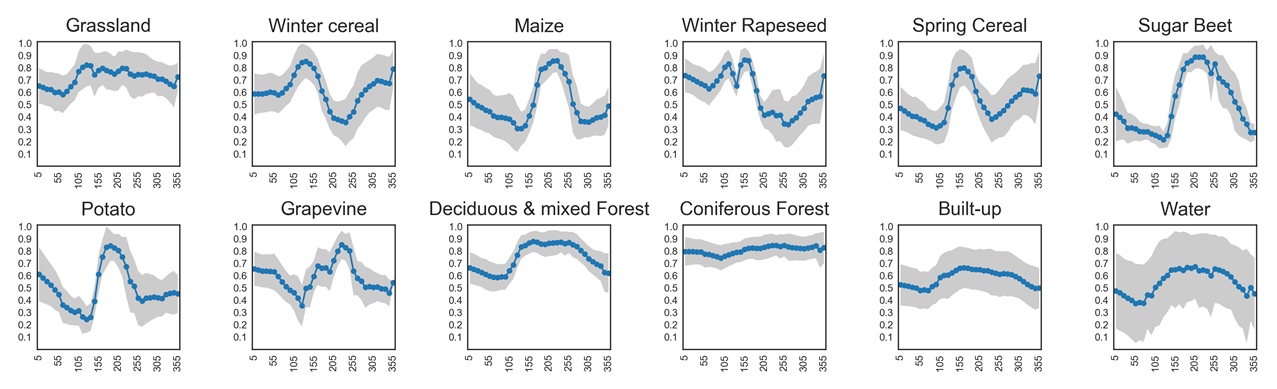

So, first we want to calculate a vegetation index such as the NDVI or the EVI. The openEO Python client supports a predefined list of spectral indices based on the 'Awesome Spectral Indices' project.


In [5]:
ndvi = compute_indices(s2_masked, ["NDVI"])

Next, we temporally aggreate to 10-day averages and apply a spatial filter to a potato field that we preselected. We calculate these averages after calculating the NDVI instead of before to avoid computing an NDVI on unobserved band combinations.

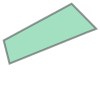

In [6]:
crop_type = "potatos"
crop_field = crop_samples[crop_type].iloc[0].geometry
crop_field

In [7]:
agg_dekad = ndvi.aggregate_temporal_period(period="dekad", reducer="mean")
ndvi_dekad = agg_dekad.apply_dimension(dimension="t", process="array_interpolate_linear")

This NDVI is calculated for every pixel in every time step t in the masked NDVI image. Now we want to aggregate all the pixels within the potato field to end up with a timeseries. We do this by calculating the mean over all the pixels as well as the standard deviation, to have an indication of the error. The more homogeneous the input area is (in this case, the potato field, but in theory you could use in any bounding box of choice), the smaller your error will be.

In [8]:
%%time
ndvi_dekad.aggregate_spatial(
    reducer=lambda pixels: array_create([mean(pixels), sd(pixels)]), 
    geometries=crop_field
).download("timeseries.csv")

CPU times: user 9.79 ms, sys: 521 µs, total: 10.3 ms
Wall time: 18.6 s


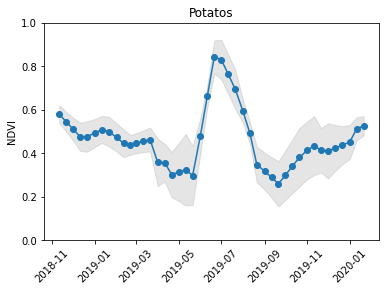

In [9]:
timeser = pd.read_csv("timeseries.csv")
timeser.index = pd.to_datetime(timeser.date)
timeser.columns = ["date", "feature_index", "Mean NDVI", "SD"]
timeser = timeser.sort_index()

plt.plot(timeser["Mean NDVI"], "o-")
plt.fill_between(
    timeser.index,
    timeser["Mean NDVI"] - timeser["SD"], 
    timeser["Mean NDVI"] + timeser["SD"],
    color='gray', alpha=0.2
)
plt.ylim(0, 1)
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.title(crop_type.title())
plt.show()